In [2]:
url = 'https://www.airlinequality.com/airline-reviews/british-airways/?sortby=post_date%3ADesc&pagesize=700'

To scrape websites with dynamic content or JavaScript rendering, you might need to use a headless browser or a tool like Selenium, which can automate browser interactions. This allows the JavaScript on the page to execute and load the dynamic content before you scrape it.

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time
import pandas as pd

# NLTK libraries
import nltk
from nltk.corpus import stopwords
import re #helps you match or find other strings or set of strings

# Visualization libraries
from matplotlib import pyplot as plt
plt.style.use('ggplot')

# VADER sentiment analysis libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm #shows the progress bar, number of iterations, time taken to run the loop, and frequency of iterations per second

# Wordcloud imports
from wordcloud import WordCloud

In [4]:
# Set up Selenium WebDriver with Brave
service = Service('D:\chromedriver_win32\chromedriver.exe')  # Replace with the path to your chromedriver executable
options = Options()
options.binary_location = "C:\\Program Files\\BraveSoftware\\Brave-Browser\\Application\\brave.exe"
options.add_argument('--headless')  # Run in headless mode (without opening a browser window)

driver = webdriver.Chrome(service=service, options=options)

# Open the website with reviews
driver.get(url)

# Wait for the reviews to load (you may need to adjust the waiting time)
driver.implicitly_wait(5)

# Extract the HTML content of the reviews section
reviews_html = driver.page_source

# Close the WebDriver
driver.quit()

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(reviews_html, 'html.parser')

In [5]:
review_list = []
# Find and process the reviews
reviews = soup.find_all('div', class_='tc_mobile')
headings = soup.find_all('h2', class_ = 'text_header')
stars = [star.find('span', itemprop='ratingValue').get_text(strip=True) for star in soup.find_all('div', itemprop='reviewRating')]

for i, review in enumerate(reviews):
    review_text = review.get_text(strip=True)
    heading_text = headings[i].get_text(strip=True)
    star_value = int(stars[i]) # Extract the first value if the list is not empty
    
     # Remove the text "✅Trip Verified | " or "Not Verified | " from the beginning of the review
    if review_text.startswith('✅Trip Verified| '):
        review_text = review_text.replace('✅Trip Verified| ', '')
    elif review_text.startswith('Not Verified| '):
        review_text = review_text.replace('Not Verified| ', '')

    review_dict = {'Title': heading_text, 'Review': review_text, 'Stars': star_value}
    review_list.append(review_dict)
# Create a DataFrame from the review list
df = pd.DataFrame(review_list)


In [6]:
# Print the DataFrame
df['Title'] = df['Title'].astype(str)
df['Review'] = df['Review'].astype(str)
df['Stars'] = df['Stars'].astype(int)
df.index.name = 'index'
df

,Title,Review,Stars
index,,,
0,"""Couldn't recommend BA more""",I had the most fantastic BA Flight today. The...,10
1,"""bumped off due to overselling""",Couldn’t book in online. Arrived at check in ...,1
2,"""a very comfortable flight""",London Heathrow to Mumbai in a Boeing 787-8 in...,9
3,"""good onboard service""","Keflavík, Iceland to London Heathrow on an A32...",6
4,"""they have really gone downhill""",Terrible Experience with British Airways. I bo...,1
...,...,...,...
695,"""trip has been really smooth""",I had a stress free journey with my 8 yr old ...,10
696,"""she looked after me so well""",Edinburgh to Kuala Lumpur via London. I have ...,10
697,"""feel worthless as a customer""",I was supposed to fly from London City to Ams...,1


### Quick EDA

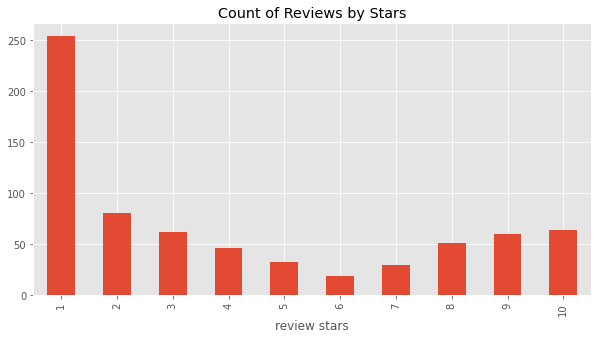

In [7]:
ax=df["Stars"].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars', figsize=(10, 5) )
ax.set_xlabel('review stars')
plt.show()

In [8]:
# Average stars:
print(df['Stars'].mean())

4.09


In [9]:
df['Stars'].describe()

count    700.000000
mean       4.090000
std        3.311516
min        1.000000
25%        1.000000
50%        3.000000
75%        7.250000
max       10.000000
Name: Stars, dtype: float64

### Data Cleaning

In [10]:
def cleaned_text(text):
    text = text.lower() # Remove the capitalization of the texts
    text = re.sub(r'[^a-zA-Z\s]', '', text) # replace the raw string text to nothing
    
    #Tokenize the text
    words = nltk.word_tokenize(text)
    
    # Remove stopwords   
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join the words after removing stopwords 
    cleaned_text = ' '.join(words)
    
    return cleaned_text

df['Title'] = df['Title'].apply(cleaned_text)
df['Review'] = df['Review'].apply(cleaned_text)
df   

,Title,Review,Stars
index,,,
0,couldnt recommend ba,fantastic ba flight today cabin crew seat zone...,10
1,bumped due overselling,couldnt book online arrived check find bumped ...,1
2,comfortable flight,london heathrow mumbai boeing business class l...,9
3,good onboard service,keflavk iceland london heathrow business class...,6
4,really gone downhill,terrible experience british airways booked fli...,1
...,...,...,...
695,trip really smooth,stress free journey yr old autistic son yr old...,10
696,looked well,edinburgh kuala lumpur via london returned kl ...,10
697,feel worthless customer,supposed fly london city amsterdam business cl...,1


## Sentiment Analysis 
using Vader(Valence Aware Dictionary and sEntiment Reasoner)

In [11]:
# pip install vaderSentiment
#  it works on particular words and says how pos/neg/nu the word is. doesnt account for relationships between words.
# nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sia

In [12]:
from tqdm import tqdm  # Assuming you have imported the tqdm library

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Create an empty dictionary to store the sentiment scores
res = {}

for col_name, col_values in tqdm(df.iteritems(), total=len(df.columns)):
    if col_name == 'Review':
        # Perform sentiment analysis on each review and store the result
        res['Review'] = col_values.apply(lambda x: sia.polarity_scores(x)['compound'])
    elif col_name == 'Title':
        # Perform sentiment analysis on each title and store the result
        res['Title'] = col_values.apply(lambda x: sia.polarity_scores(x)['compound'])


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\gupta\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py:1178: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for obj in iterable:
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s]


In [13]:
print(df.index.name)

index


In [14]:
# lets store it in pandas dataframe
vaders= pd.DataFrame(res)
vaders=vaders.reset_index().rename(columns={'index':'index'})  #we renamed because we want to merge on Id
vaders=vaders.merge(df,on ='index', how='left')
vaders

,index,Title_x,Review_x,Title_y,Review_y,Stars
0,0,-0.2755,0.9948,couldnt recommend ba,fantastic ba flight today cabin crew seat zone...,10
1,1,-0.2023,0.6808,bumped due overselling,couldnt book online arrived check find bumped ...,1
2,2,0.5106,0.9753,comfortable flight,london heathrow mumbai boeing business class l...,9
3,3,0.4404,0.0772,good onboard service,keflavk iceland london heathrow business class...,6
4,4,0.0000,-0.6134,really gone downhill,terrible experience british airways booked fli...,1
...,...,...,...,...,...,...
695,695,0.0000,0.9808,trip really smooth,stress free journey yr old autistic son yr old...,10
696,696,0.2732,0.9536,looked well,edinburgh kuala lumpur via london returned kl ...,10
697,697,-0.4404,-0.9371,feel worthless customer,supposed fly london city amsterdam business cl...,1
698,698,-0.2500,-0.8510,asked cancel ticket,purchased ticket dublin mauritius british airw...,1


In [15]:
def get_sentiment_label(polarity_score):
    if polarity_score < -0.30:
        return 'neg'
    elif -0.30 < polarity_score < 0.30:
        return 'neu'
    else:
        return 'pos'

# Apply the sentiment analysis to each row in 'Title_x' column
vaders['TitleSentiment'] = vaders['Title_x'].apply(lambda x: get_sentiment_label(x))
vaders['ReviewSentiment'] = vaders['Review_x'].apply(lambda x: get_sentiment_label(x))

vaders

,index,Title_x,Review_x,Title_y,Review_y,Stars,TitleSentiment,ReviewSentiment
0,0,-0.2755,0.9948,couldnt recommend ba,fantastic ba flight today cabin crew seat zone...,10,neu,pos
1,1,-0.2023,0.6808,bumped due overselling,couldnt book online arrived check find bumped ...,1,neu,pos
2,2,0.5106,0.9753,comfortable flight,london heathrow mumbai boeing business class l...,9,pos,pos
3,3,0.4404,0.0772,good onboard service,keflavk iceland london heathrow business class...,6,pos,neu
4,4,0.0000,-0.6134,really gone downhill,terrible experience british airways booked fli...,1,neu,neg
...,...,...,...,...,...,...,...,...
695,695,0.0000,0.9808,trip really smooth,stress free journey yr old autistic son yr old...,10,neu,pos
696,696,0.2732,0.9536,looked well,edinburgh kuala lumpur via london returned kl ...,10,neu,pos
697,697,-0.4404,-0.9371,feel worthless customer,supposed fly london city amsterdam business cl...,1,neg,neg
698,698,-0.2500,-0.8510,asked cancel ticket,purchased ticket dublin mauritius british airw...,1,neu,neg


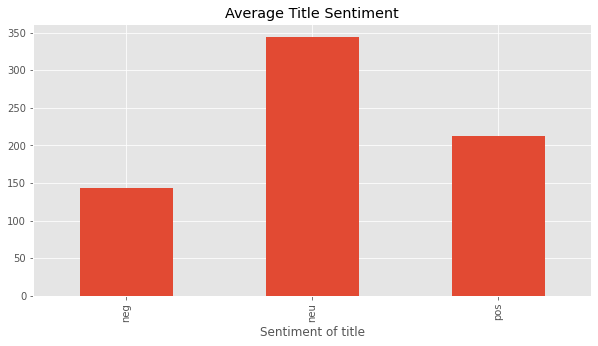

In [16]:
ax=vaders["TitleSentiment"].value_counts().sort_index().plot(kind='bar',title='Average Title Sentiment', figsize=(10, 5) )
ax.set_xlabel('Sentiment of title')
plt.show()

In [17]:
vaders["TitleSentiment"].value_counts()

neu    344
pos    212
neg    144
Name: TitleSentiment, dtype: int64

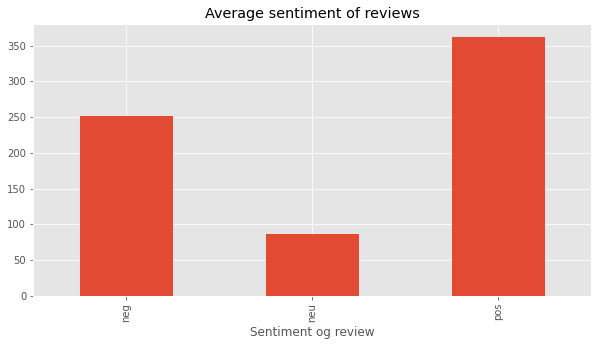

In [18]:
ax=vaders["ReviewSentiment"].value_counts().sort_index().plot(kind='bar',title='Average sentiment of reviews', figsize=(10, 5) )
ax.set_xlabel('Sentiment og review')
plt.show()

## Wordcloud

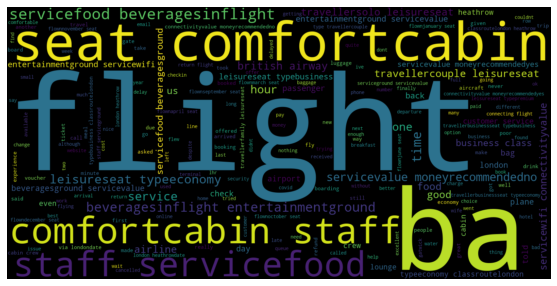

In [19]:
all_reviews = ' '.join(vaders['Review_y'])
wordcloud = WordCloud(width=1600, height=800).generate(all_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()